Scratch pad to develop the dynamically-constrained super-resolution training pipeline. 

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import jax
import jax.numpy as jnp
import numpy as np

import jax_cfd.base as cfd

In [2]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True
})

In [3]:
# setup problem and create grid
Lx = 2 * jnp.pi
Ly = 2 * jnp.pi
Nx = 128
Ny = 128
Re = 100.

DATA_SCALE = 4

grid = cfd.grids.Grid((Nx, Ny), domain=((0, Lx), (0, Ly)))

# estimate stable time step based on a "max velocity" using CFL condition
max_vel_est = 5.
dt_stable = cfd.equations.stable_time_step(max_vel_est, 0.5, 1./Re, grid) / 2.

First point to the data (small trajectories) and view to make sure appearance is realistic

In [4]:
data_loc = '/Users/jpage2/code/jax-cfd-data-gen/Re100test/'
file_front = 'vort_traj.'
n_zeros = 4

In [5]:
# add a new axis for "channels" and a new axis for "batch" (at front)
vort_example_traj = np.load(data_loc + file_front + str(70).zfill(4) + '.npy')[np.newaxis, :, :, :,np.newaxis]
vort_example_traj.shape

(1, 100, 128, 128, 1)

In [6]:
def average_pool_trajectory(omega_traj, pool_width, pool_height):
  batch_size, trajectory_length, Nx, Ny, Nchannels = omega_traj.shape
  assert Nx % pool_width == 0
  assert Ny % pool_height == 0

  omega_reshaped = omega_traj.reshape(
    (batch_size, trajectory_length, Nx // pool_width, pool_width, Ny // pool_height, pool_height, Nchannels)
  )
  omega_pooled_traj = omega_reshaped.mean(axis=(3, 5))
  return omega_pooled_traj

def coarse_pool_trajectory(omega_traj, pool_width, pool_height):
  _, _, Nx, Ny, _ = omega_traj.shape
  assert Nx % pool_width == 0
  assert Ny % pool_height == 0

  coarse_x = pool_width
  coarse_y = pool_height

  omega_pooled_traj = omega_traj[:, :, ::coarse_x, :: coarse_y, :]
  return omega_pooled_traj

# pooling_fn = jax.jit(average_pool_trajectory, static_argnums=(1, 2))
pooling_fn = jax.jit(coarse_pool_trajectory, static_argnums=(1, 2))

In [7]:
filter_size = 16
vort_traj_pooled = pooling_fn(vort_example_traj, filter_size, filter_size)

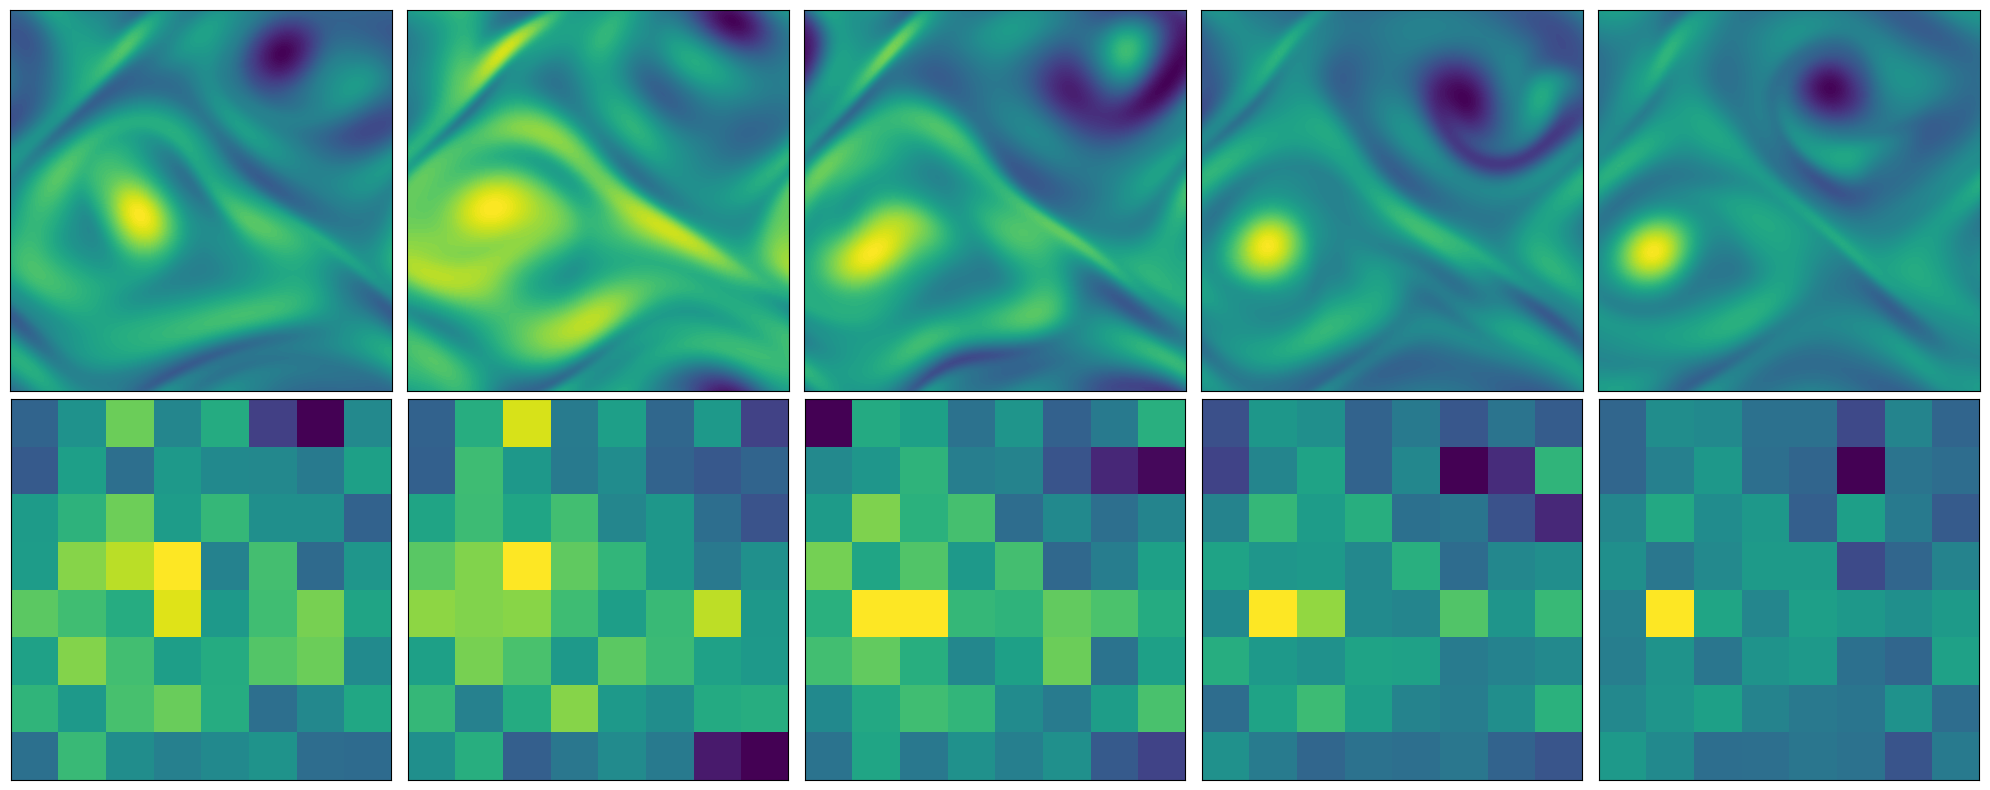

In [8]:
vort_traj_plot = jnp.squeeze(vort_example_traj)[:5]
vort_coarse_plot = jnp.squeeze(vort_traj_pooled)[:5]

import matplotlib.pyplot as plt

num_axes = len(vort_traj_plot)

fig = plt.figure(figsize=(4 * num_axes, 8))
ax_num = 1
for vort, vort_coarse in zip(vort_traj_plot, vort_coarse_plot):
  ax = fig.add_subplot(2, num_axes, ax_num)
  ax.contourf(vort.T, 101)
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(2, num_axes, ax_num + num_axes)
  ax.imshow(vort_coarse.T, origin='lower')
  ax.set_xticks([])
  ax.set_yticks([])

  ax_num += 1
fig.tight_layout()

Let's build the ResNet-type model we will use to perform super resolution. The model should simply operate on batches of images, we need the loss (and data loading) to see the full trajectory though.

Bit of a fudge as we start to expand the number of models. Ideally need a label in the config file...

In [65]:
import models 
# super_model = models.super_res_v0(Nx // filter_size, Ny // filter_size, 32, N_grow=3, input_channels=2)
super_model = models.super_res_vel_v1(Nx // filter_size, Ny // filter_size, 32, N_grow=4, input_channels=2)
# super_model = models.super_res_vel_v2(Nx // filter_size, Ny // filter_size, 32, N_grow=4, input_channels=2)

# super_model.load_weights('weights/sr_best_MSE.weights.h5')
super_model.load_weights('weights/sr_best_traj.weights.h5') 

In [66]:
super_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 8, 8, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_55 (Lambda)  │ (None, 11, 11, 2) │          0 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 8, 8, 32)  │      1,056 │ lambda_55[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_20    │ (None, 16, 16,    │          0 │ conv2d_50[0][0]   │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ up_sampling2d_20… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_56 (Lambda)  │ (None, 19, 19,    │          0 │ activation_20[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 16, 16,    │     16,416 │ lambda_56[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ conv2d_51[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_57 (Lambda)  │ (None, 19, 19,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 16, 16,    │     16,416 │ lambda_57[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 16, 16,    │          0 │ conv2d_52[0][0],  │
│                     │ 32)               │            │ up_sampling2d_20… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_21    │ (None, 32, 32,    │          0 │ add_20[0][0]      │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ up_sampling2d_21… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_58 (Lambda)  │ (None, 35, 35,    │          0 │ activation_21[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 32, 32,    │     16,416 │ lambda_58[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 134,434 (525.13 KB)

 Trainable params: 133,922 (523.13 KB)

 Non-trainable params: 512 (2.00 KB)

Objective would be to initially pre-train this model on the pure reconstruction problem, prior to using the trajectory information in the loss.

Let's first verify we can run it on a small subset of the training data and train OK. 

Slightly awkward since we ultimately want to train on batches of trajectories, so for our initial tests involves some awkward reshaping

In [31]:
vort_snapshots = jnp.array([np.load(data_loc + file_front + str(n).zfill(4) + '.npy')[np.newaxis, 0, :, :, np.newaxis] for n in range(1000)])
# vort_snapshots_coarse = average_pool_trajectory(vort_snapshots, filter_size, filter_size)
vort_snapshots_coarse = coarse_pool_trajectory(vort_snapshots, filter_size, filter_size)

vort_snapshots = vort_snapshots[:, 0]
vort_snapshots_coarse = vort_snapshots_coarse[:, 0]

In [32]:
vort_snapshots_coarse.shape

(1000, 8, 8, 1)

In [33]:
n_plot = 5

fig = plt.figure(figsize=(4 * n_plot, 12))
ax_num = 1

mask = np.zeros(len(vort_snapshots), dtype=bool)
mask[:n_plot] = True
np.random.shuffle(mask)

# # for vort, vort_coarse in zip(vort_snapshots[:n_plot], vort_snapshots_coarse[:n_plot]):
# for vort, vort_coarse in zip(vort_snapshots[mask], vort_snapshots_coarse[mask]):
#   ax = fig.add_subplot(3, num_axes, ax_num)
#   ax.contourf(vort[:, :, 0].T, 101)
#   ax.set_xticks([])
#   ax.set_yticks([])

#   ax = fig.add_subplot(3, num_axes, ax_num + num_axes)
#   ax.imshow(vort_coarse[:, :, 0].T, origin='lower')
#   ax.set_xticks([])
#   ax.set_yticks([])

#   ax = fig.add_subplot(3, num_axes, ax_num + 2 * num_axes)
#   vort_pred = super_model.predict(vort_coarse.reshape(
#     (1, Nx // filter_size, Ny // filter_size, 1))
#     )
  
#   rel_error = jnp.linalg.norm(vort_pred.flatten() - vort.flatten()) / jnp.linalg.norm(vort.flatten())
#   print(rel_error)

#   # print(jnp.mean((vort_pred.reshape((Nx, Ny)) - vort[:, :, 0]) ** 2))

#   ax.contourf(vort_pred[0, :, :, 0].T, 101)
#   ax.set_xticks([])
#   ax.set_yticks([])

#   ax_num += 1
# fig.tight_layout()

<Figure size 2000x1200 with 0 Axes>

Try velocity formulation

In [34]:
import interact_model as im
vort_batch = vort_snapshots[mask]
vel_batch = im.compute_vel_traj(vort_batch, Lx / Nx, Ly / Ny)

vort_recon = im.compute_vort_traj(vel_batch, Lx / Nx, Ly / Ny)
print(jnp.linalg.norm((vort_batch - vort_recon).flatten()) / jnp.linalg.norm(vort_batch.flatten()))

2.7436597e-06


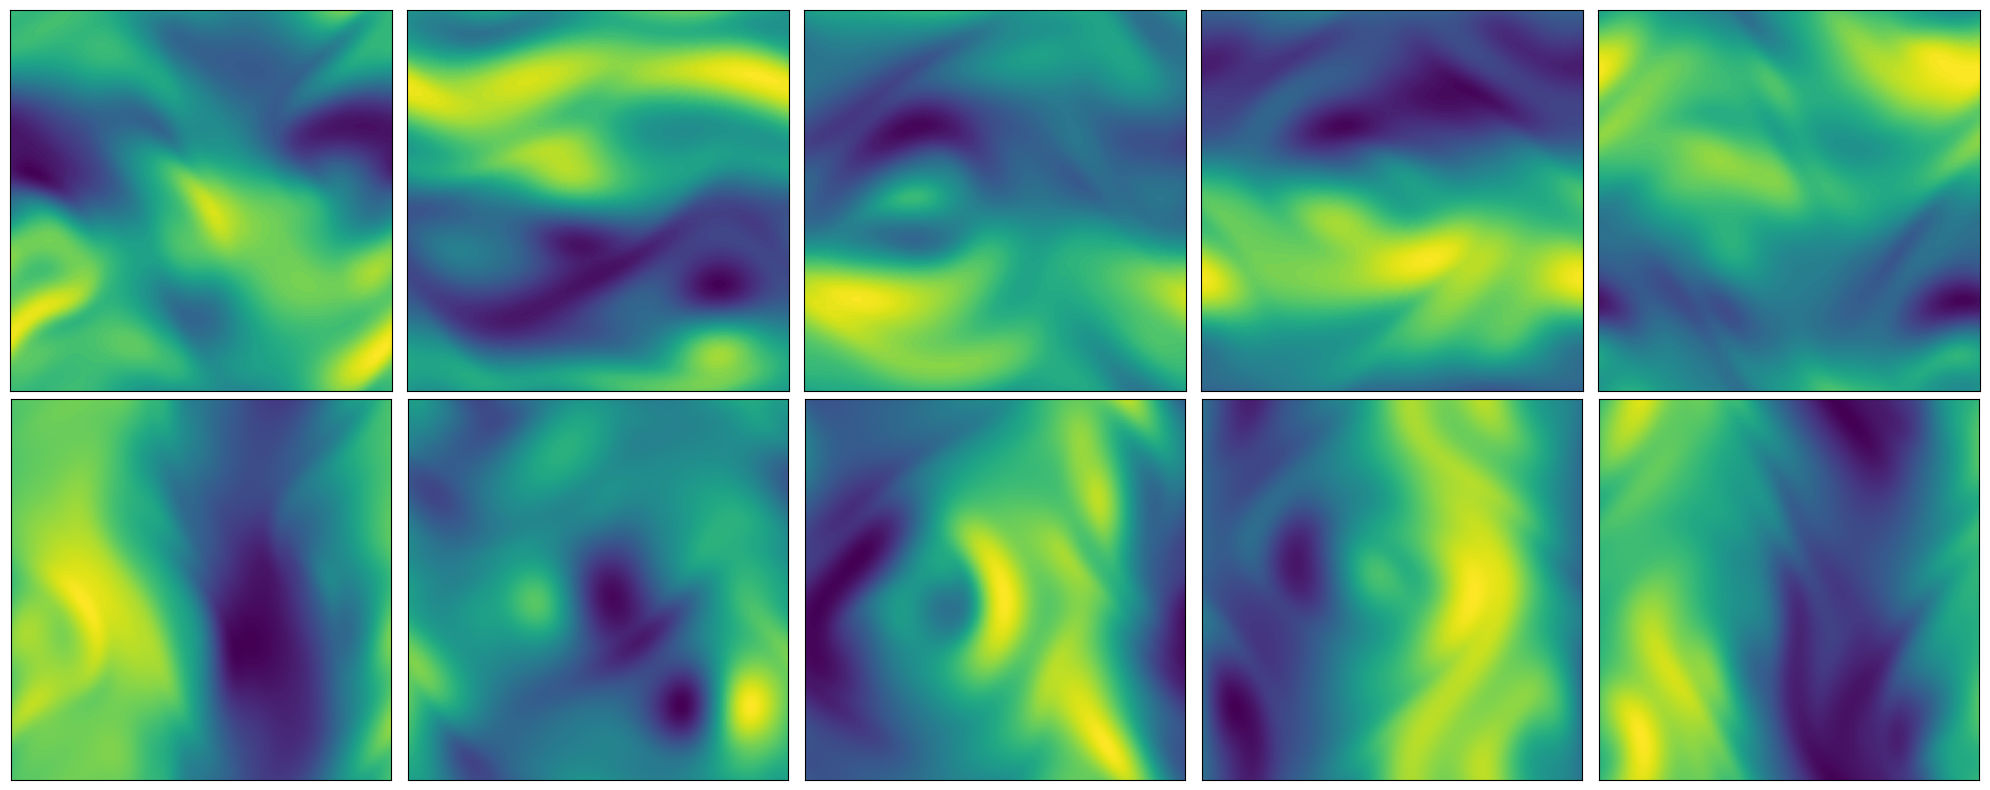

In [35]:

fig = plt.figure(figsize=(4 * n_plot, 8))
ax_num = 1
num_axes = len(vel_batch)

# for vort, vort_coarse in zip(vort_snapshots[:n_plot], vort_snapshots_coarse[:n_plot]):
for vel_x, vel_y in zip(vel_batch[...,0], vel_batch[...,1]):
  ax = fig.add_subplot(2, num_axes, ax_num)
  ax.contourf(vel_x.T, 101)
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(2, num_axes, ax_num + num_axes)
  ax.imshow(vel_y.T, origin='lower')
  ax.set_xticks([])
  ax.set_yticks([])

  ax_num += 1
fig.tight_layout()

In [36]:
coarse_vel_batch = coarse_pool_trajectory(vel_batch[jnp.newaxis,...], filter_size, filter_size).squeeze()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
0.16874464
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
0.24506755
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
0.18077171
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
0.16513422
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
0.17154044


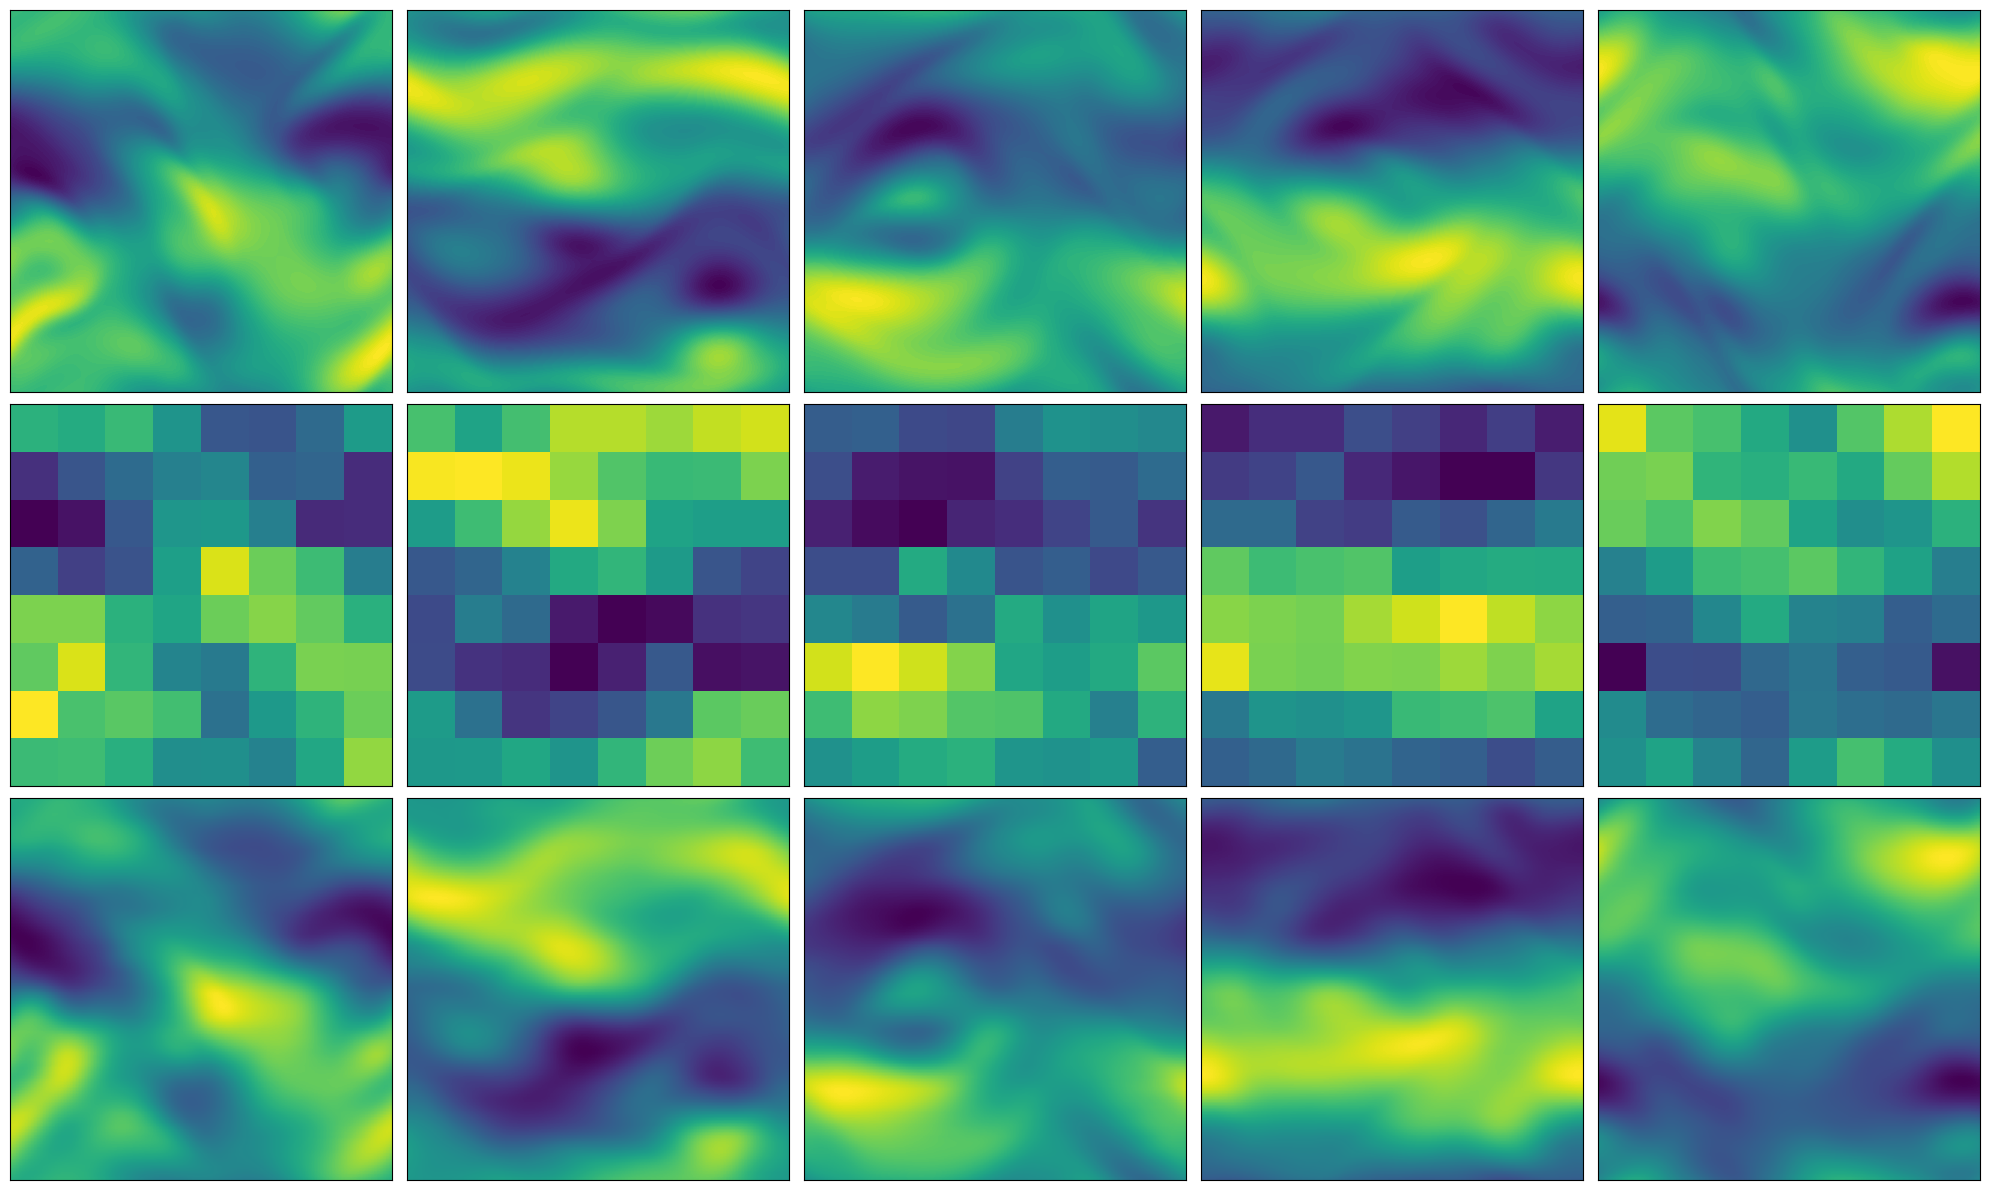

In [67]:
fig = plt.figure(figsize=(4 * n_plot, 12))
ax_num = 1

vel_comp = 0

for vel, vel_coarse in zip(vel_batch, coarse_vel_batch):
  vel_pred = super_model.predict(vel_coarse.reshape((
    1, Nx // filter_size, Ny // filter_size, 2))
    )
  rel_error = jnp.linalg.norm(vel_pred.flatten() - vel.flatten()) / jnp.linalg.norm(vel.flatten())
  print(rel_error)  

  ax = fig.add_subplot(3, num_axes, ax_num)
  ax.contourf(vel[...,vel_comp].squeeze().T, 101)
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(3, num_axes, ax_num + num_axes)
  ax.imshow(vel_coarse[:, :, vel_comp].T, origin='lower')
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(3, num_axes, ax_num + 2 * num_axes)
  ax.imshow(vel_pred[...,vel_comp].squeeze().T, origin='lower')
  ax.set_xticks([])
  ax.set_yticks([])

  ax_num += 1
fig.tight_layout()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
0.4355395
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
0.5167158
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
0.40653855
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
0.4199838
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
0.4761152


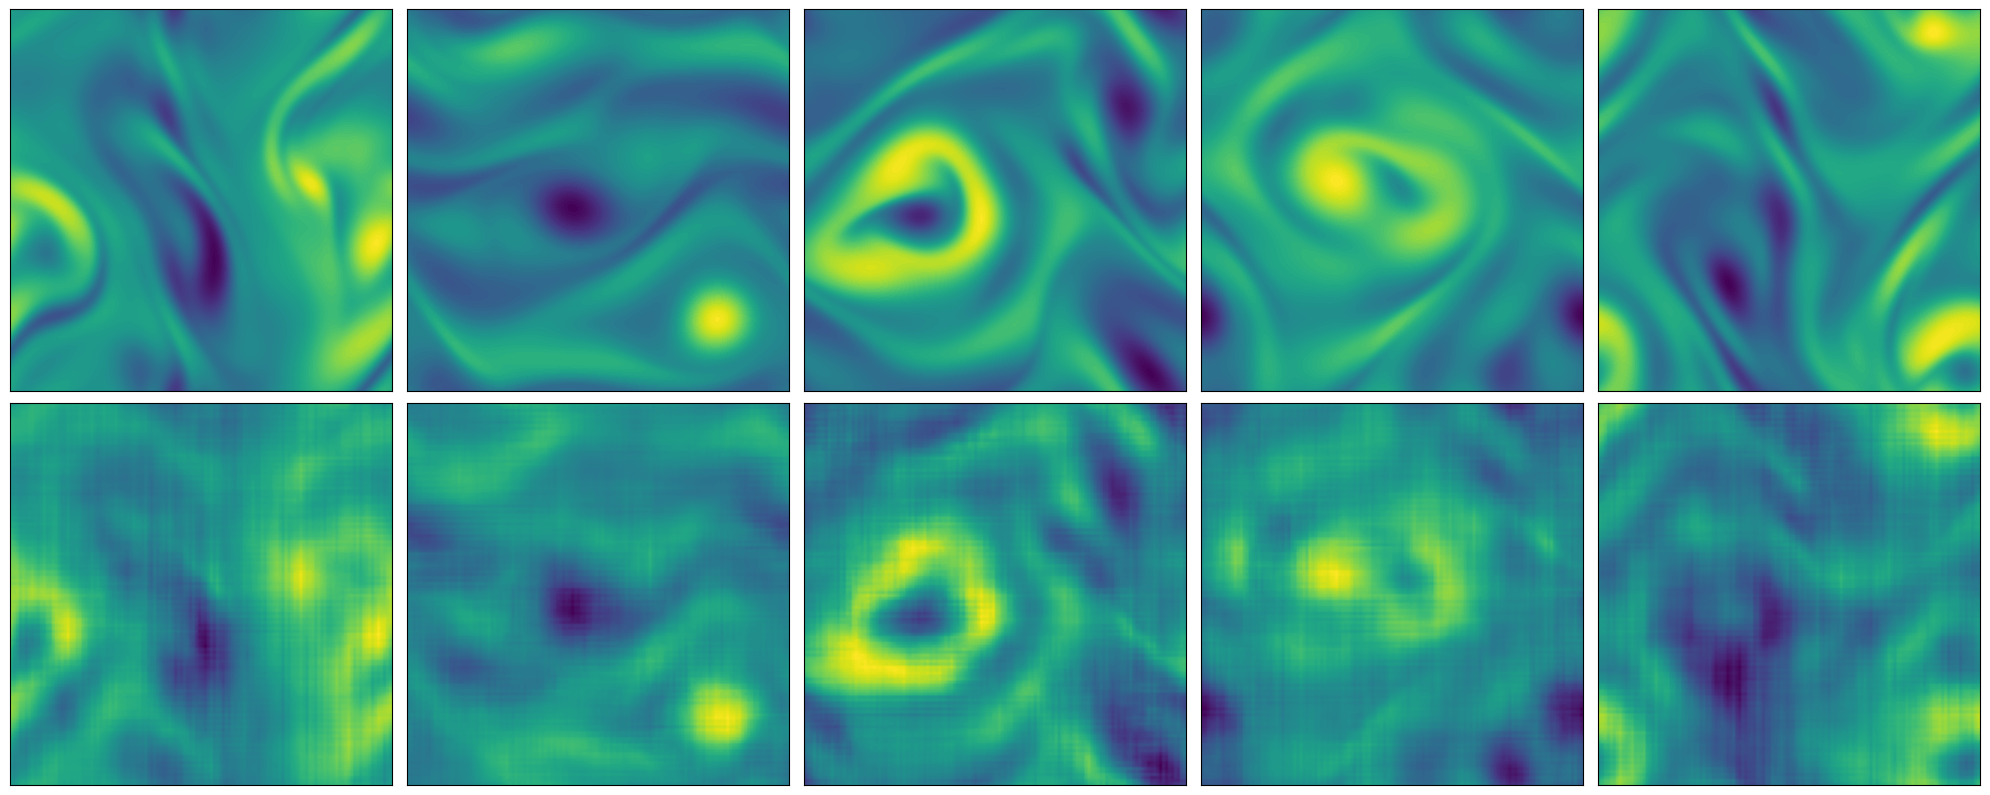

In [68]:
fig = plt.figure(figsize=(4 * n_plot, 12))
ax_num = 1

for vel, vel_coarse in zip(vel_batch, coarse_vel_batch):
  vel_pred = super_model.predict(vel_coarse.reshape((
    1, Nx // filter_size, Ny // filter_size, 2))
    )
  
  vort_true = im.compute_vort_traj(vel.reshape((1, Nx, Ny, 2)), Lx / Nx, Ly / Ny)
  vort_pred = im.compute_vort_traj(vel_pred.reshape((1, Nx, Ny, 2)), Lx / Nx, Ly / Ny)

  rel_error = jnp.linalg.norm(vort_pred.flatten() - vort_true.flatten()) / jnp.linalg.norm(vort_true.flatten())
  print(rel_error)  


  ax = fig.add_subplot(3, num_axes, ax_num)
  ax.contourf(vort_true.squeeze().T, 101)
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(3, num_axes, ax_num + num_axes)
  ax.imshow(vort_pred.squeeze().T, origin='lower')
  ax.set_xticks([])
  ax.set_yticks([])

  # # have a look at induced vel... reasonable?
  # vel_pred = im.compute_vel_traj(vort_pred.reshape((1, Nx, Ny, 1)), Lx / Nx, Ly / Ny)
  # ax = fig.add_subplot(3, num_axes, ax_num + 2 * num_axes)
  # ax.imshow(vel_pred[...,0].squeeze().T, origin='lower')
  # ax.set_xticks([])
  # ax.set_yticks([])


  ax_num += 1
fig.tight_layout()

Is the output solenoidal? The velocity algorithm goes like

coarse field -> well resolved field -> compute vorticity -> evolve -> compute indced velocity -> compare

Trouble is that there is no penalty for the well resolved field being div-free. But there is no benefit to it either. So what happens?

In [22]:
def compute_div_of_snap(field, dx, dy):
  Nx, Ny, _ = field.shape
  field_rft = jnp.fft.rfftn(field, axes=(0,1))
  u_rft = field_rft[..., 0]
  v_rft = field_rft[..., 1]

  all_kx = 2 * jnp.pi * jnp.fft.fftfreq(Nx, dx)
  all_ky = 2 * jnp.pi * jnp.fft.rfftfreq(Ny, dy)
  
  kx_mesh, ky_mesh = jnp.meshgrid(all_kx, all_ky)

  ikxu = 1j * kx_mesh.T * u_rft
  ikyv = 1j * ky_mesh.T * v_rft
  return jnp.fft.irfftn(ikxu + ikyv)

In [23]:
indx = 0
vel = vel_batch[indx]
vel_coarse = coarse_vel_batch[indx]

vel_pred = super_model.predict(vel_coarse.reshape(
  (1, Nx // filter_size, Ny // filter_size, 2)
  )
  )[0]

div_vel = compute_div_of_snap(vel, Lx / Nx, Ly / Ny)
div_vel_pred = compute_div_of_snap(vel_pred, Lx / Nx, Ly / Ny)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [24]:
print(
  np.linalg.norm(div_vel.flatten()) / np.linalg.norm(vel.flatten()),
  np.linalg.norm(div_vel_pred.flatten()) / np.linalg.norm(vel_pred.flatten())
)

3.6962208e-06 0.00017989564


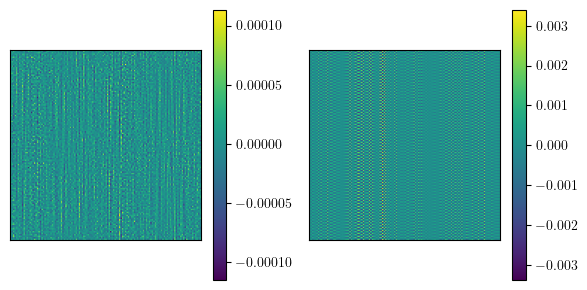

In [25]:
fig = plt.figure(figsize=(6, 3))

ax = fig.add_subplot(1, 2, 1)
c = ax.imshow(div_vel.T)
cbar = plt.colorbar(c)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(1, 2, 2)
c = ax.imshow(div_vel_pred.T)
cbar = plt.colorbar(c)
ax.set_xticks([])
ax.set_yticks([])

fig.tight_layout()

Spectral content. 

In [26]:
def compute_average_energy_spectrum(
  vel_batch: jnp.ndarray,
  dk = 1.,
  k_max = None
):
  if len(vel_batch.shape) == 3:
    vel_batch = vel_batch[jnp.newaxis, ...]
  
  # setup Fourier grid
  all_kx = 2 * jnp.pi * jnp.fft.fftfreq(Nx, 2 * jnp.pi / Nx)
  all_ky = 2 * jnp.pi * jnp.fft.fftfreq(Ny,  2 * jnp.pi / Ny)
  kx_mesh, ky_mesh = jnp.meshgrid(
    all_kx,
    all_ky
    )
  if k_max == None:
    k_max = int(1.5 * jnp.max(all_kx))
  
  abs_wavenumbers = jnp.sqrt(kx_mesh ** 2 + ky_mesh ** 2)

  # construct spectral energy
  vel_batch_ft = jnp.fft.fftn(vel_batch, axes=(1,2))
  ke_in_kxky = 0.5 * jnp.sum(
    jnp.abs(vel_batch_ft * vel_batch_ft.conj()),
    axis=-1
  ) / (Nx * Ny) ** 2

  k_grid = []
  E_k = []
  for k in range(0, k_max):
    k_grid.append(k * dk)
    kx_ky_indices = (abs_wavenumbers >= k) & (abs_wavenumbers < k + dk)
    E_k.append(jnp.sum(
      jnp.mean(ke_in_kxky[:, kx_ky_indices], axis=0)
      ))
  return k_grid, E_k

def compute_average_enstrophy_spectrum(
  vel_batch: jnp.ndarray,
  dk = 1.,
  k_max = None
):
  if len(vel_batch.shape) == 3:
    vel_batch = vel_batch[jnp.newaxis, ...]
  
  # setup Fourier grid
  all_kx = 2 * jnp.pi * jnp.fft.fftfreq(Nx, 2 * jnp.pi / Nx)
  all_ky = 2 * jnp.pi * jnp.fft.fftfreq(Ny,  2 * jnp.pi / Ny)
  kx_mesh, ky_mesh = jnp.meshgrid(
    all_kx,
    all_ky
    )
  if k_max == None:
    k_max = int(1.5 * jnp.max(all_kx))

  abs_wavenumbers = jnp.sqrt(kx_mesh ** 2 + ky_mesh ** 2)

  # construct spectral enstrophy
  vort_batch = im.compute_vort_traj(vel_batch, Lx / Nx, Ly / Ny)
  vort_batch_ft = jnp.fft.fftn(vort_batch, axes=(1,2))
  enst_in_kxky = 0.5 * jnp.sum(
    jnp.abs(vort_batch_ft * vort_batch_ft.conj()),
    axis=-1
  ) / (Nx * Ny) ** 2

  k_grid = []
  Om_k = []
  for k in range(0, k_max):
    k_grid.append(k * dk)
    kx_ky_indices = (abs_wavenumbers >= k) & (abs_wavenumbers < k + dk)
    Om_k.append(jnp.sum(
      jnp.mean(enst_in_kxky[:, kx_ky_indices], axis=0)
      ))
  return k_grid, Om_k

In [27]:
k_grid, E_k_batch = compute_average_energy_spectrum(vel_batch)

vel_pred_batch = super_model.predict(coarse_vel_batch)
_, E_k_recon = compute_average_energy_spectrum(vel_pred_batch)

_, Om_k_batch = compute_average_enstrophy_spectrum(vel_batch)
_, Om_k_recon = compute_average_enstrophy_spectrum(vel_pred_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


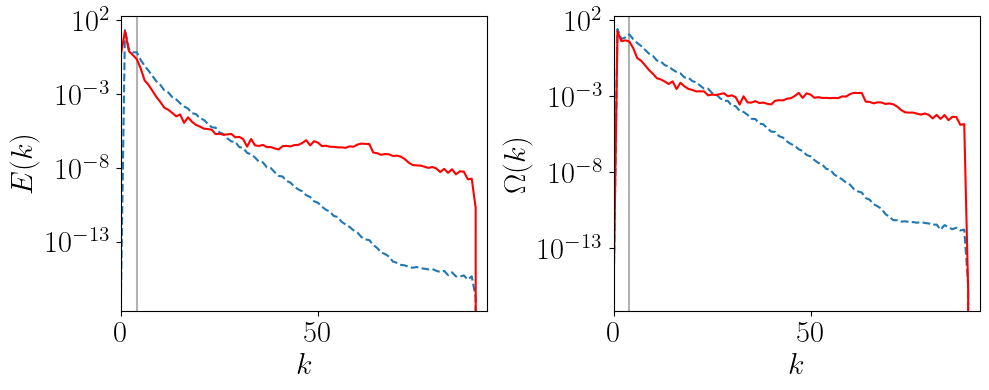

In [28]:
fig = plt.figure(figsize=(10, 4))

# energy
ax = fig.add_subplot(1, 2, 1)
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)

# plot forcing wavenumber
ax.axvline(x=4., c='k', alpha=0.3)

ax.plot(k_grid, E_k_batch, '--')
ax.plot(k_grid, E_k_recon, 'r')


ax.set_xlim(0, max(k_grid))

ax.set_xlabel(r'$k$', fontsize=22)
ax.set_ylabel(r'$E(k)$', fontsize=22)
ax.set_yscale('log')


# enstrophy
ax = fig.add_subplot(1, 2, 2)
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)

# plot forcing wavenumber
ax.axvline(x=4., c='k', alpha=0.3)

ax.plot(k_grid, Om_k_batch, '--')
ax.plot(k_grid, Om_k_recon, 'r')


ax.set_xlim(0, max(k_grid))

ax.set_xlabel(r'$k$', fontsize=22)
ax.set_ylabel(r'$\Omega(k)$', fontsize=22)
ax.set_yscale('log')

fig.tight_layout()

Investigate how the unroll plays out for example trajectories.

In [47]:
from functools import partial
import time_stepping as ts
M_substep = filter_size
T_unroll = 10.
T_da = 1.5
vel_assim = True

dt_stable = np.round(dt_stable, 3)
t_substep = M_substep * dt_stable
trajectory_fn = ts.generate_trajectory_fn(Re, T_unroll + 1e-2, dt_stable, grid, t_substep=t_substep)

def real_to_real_traj_fn(vort_phys, trajectory_fn):
  vort_rft = jnp.fft.rfftn(vort_phys, axes=(0,1))
  _, vort_traj_rft = trajectory_fn(vort_rft)
  return jnp.fft.irfftn(vort_traj_rft, axes=(1,2))

real_traj_fn = partial(real_to_real_traj_fn, trajectory_fn=trajectory_fn)

In [70]:
snap_int = 0 # within batch
vort_true = vort_batch[snap_int]
vel_pred = super_model.predict(
  coarse_vel_batch[snap_int].reshape((1, Nx // filter_size, Ny // filter_size, 2))
  )
vort_pred = im.compute_vort_traj(vel_pred.reshape((1, Nx, Ny, 2)), Lx / Nx, Ly / Ny)[0]

true_trajectory = real_traj_fn(vort_true[...,0])
pred_trajectory = real_traj_fn(vort_pred[...,0])

if vel_assim == True:
  true_trajectory = im.compute_vel_traj(true_trajectory[..., jnp.newaxis], Lx / Nx, Ly / Ny)
  pred_trajectory = im.compute_vel_traj(pred_trajectory[..., jnp.newaxis], Lx / Nx, Ly / Ny)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [71]:
t_grid = np.linspace(M_substep * dt_stable, 
                     len(true_trajectory) * M_substep * dt_stable, 
                     len(true_trajectory))

error_pred = []
for n, _ in enumerate(t_grid):
  if vel_assim == True:
    e_p = jnp.linalg.norm((true_trajectory[n] - pred_trajectory[n]).flatten()) / jnp.linalg.norm(vel_batch[snap_int].flatten())
  else:
    e_p = jnp.linalg.norm((true_trajectory[n] - pred_trajectory[n]).flatten()) / jnp.linalg.norm(vort_true.flatten())
  error_pred.append(e_p)

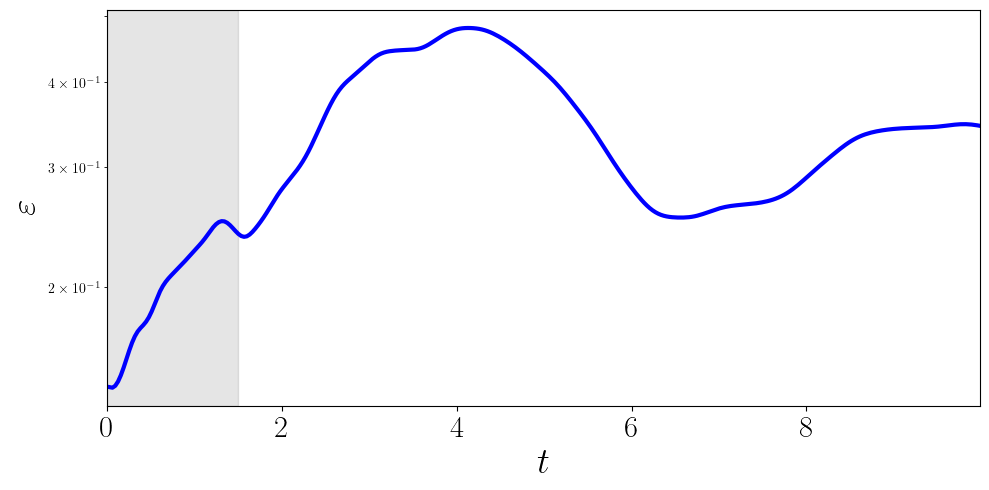

In [72]:
fig = plt.figure(figsize=(10, 5)) 
ax1 = fig.add_subplot(1, 1, 1)
ax1.tick_params(labelsize=22)

ax1.axvspan(0, T_da, color='k', alpha=0.1)

ax1.plot(t_grid, error_pred, c='b', linewidth=3)
  
ax1.set_xlabel(r'$t$', fontsize=26)
ax1.set_ylabel(r'$\varepsilon$', fontsize=26)

ax1.set_xlim(0, t_grid[-1])
ax1.set_yscale('log')

fig.tight_layout()

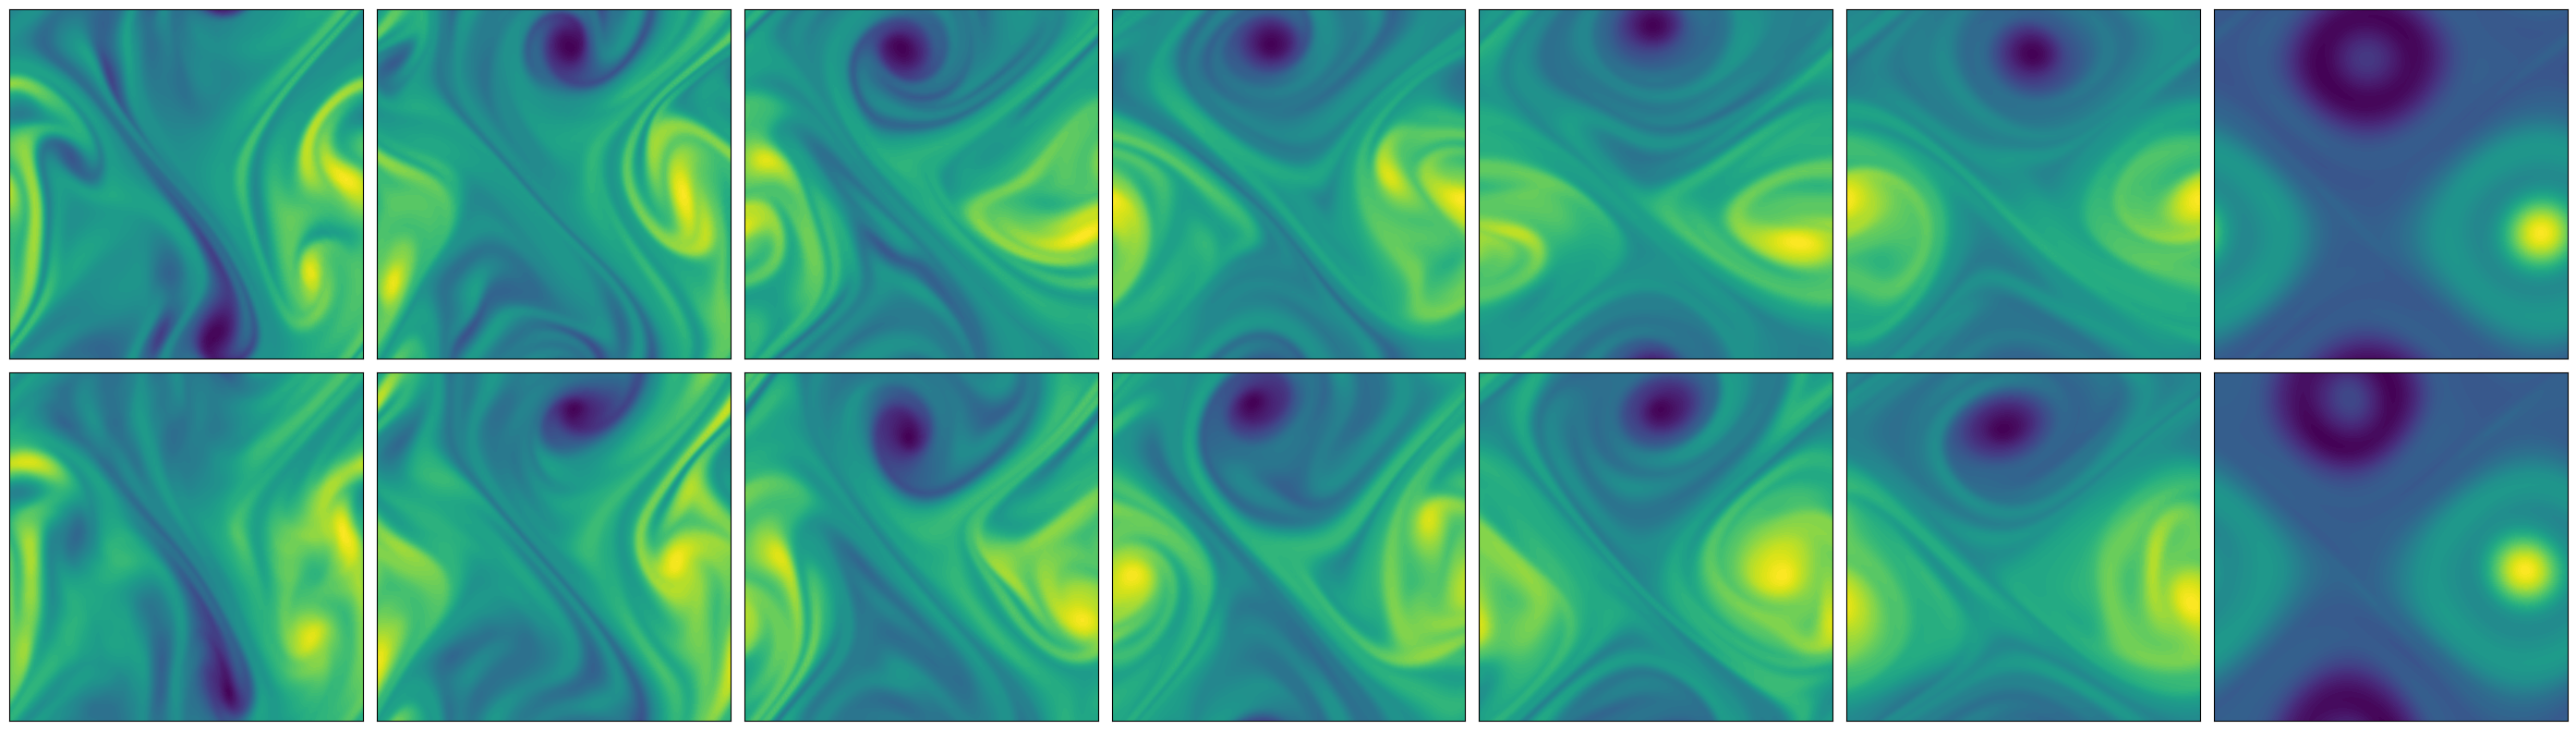

In [73]:
T_extract = [0.25, 0.5, 0.75, 1., 1.5, 2., 10.]
N_extract = [int(t_e / (M_substep * dt_stable)) for t_e in T_extract]

n_plot = len(N_extract)

fig = plt.figure(figsize=(4 * n_plot, 8))
ax_num = 1

v_comp = 2 # if vel assim, which component to plot? if set to "2" -> plot vorticity

# compute vort (again ... ) if plotting
if v_comp > 1:
  vort_true_traj = im.compute_vort_traj(true_trajectory, Lx / Nx, Ly / Ny)[..., 0]
  vort_pred_traj = im.compute_vort_traj(pred_trajectory, Lx / Nx, Ly / Ny)[..., 0]

# for vort, vort_coarse in zip(vort_snapshots[:n_plot], vort_snapshots_coarse[:n_plot]):
for n in N_extract:
  if vel_assim == True:
    if v_comp < 2:
      v_true = true_trajectory[n, ..., v_comp]
      v_pred = pred_trajectory[n, ..., v_comp]
    else:
      v_true = vort_true_traj[n]
      v_pred = vort_pred_traj[n]
  else:
    v_true = true_trajectory[n]
    v_pred = pred_trajectory[n]

  ax = fig.add_subplot(2, n_plot, ax_num)
  ax.contourf(v_true.T, 101)
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(2, n_plot, ax_num + n_plot)
  ax.contourf(v_pred.T, 101)
  ax.set_xticks([])
  ax.set_yticks([])

  ax_num += 1
fig.tight_layout()